# 機器學習 作業匯總

In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from tqdm import tqdm


# 路徑設置
for dirname, _, filenames in os.walk('/kaggle/input/carinsuranceclaimprediction-classification'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# 讀取 CSV 文件
csv_path = '/kaggle/input/carinsuranceclaimprediction-classification/train.csv'
metaData = pd.read_csv(csv_path, header=0)

/kaggle/input/carinsuranceclaimprediction-classification/sample_submission.csv
/kaggle/input/carinsuranceclaimprediction-classification/train.csv
/kaggle/input/carinsuranceclaimprediction-classification/test.csv


# 資料處理

In [24]:
# 刪除第一、十一、十二列的單元格
metaData = metaData.drop(columns=[metaData.columns[0], metaData.columns[10], metaData.columns[11]])

# 定義一個自定義函數，對非數字進行編碼
def encode_non_numeric(column):
    if column.dtype == 'object':
        return column.astype('category').cat.codes
    return column

# 將所有非數字的單元格進行編碼
metaData = metaData.apply(encode_non_numeric)

In [25]:
# 自定义函数来划分数据集为训练集和验证集
def split_train_validation(data, test_ratio=0.2):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

# 使用函数划分训练集和验证集
train_set, validation_set = split_train_validation(metaData, test_ratio=0.2)

#train_set = train_set.sample(frac=0.1)
#validation_set = validation_set.sample(frac=0.1)

# 显示结果
#print(f"Training set size: {(train_set)}")
#print(f"Validation set size: {len(validation_set)}")

print(train_set.shape)
print(validation_set.shape)

(46874, 38)
(11718, 38)


In [26]:
# 准备数据
X_train = train_set.drop('is_claim', axis=1)
y_train = train_set['is_claim']
X_validation = validation_set.drop('is_claim', axis=1)
y_validation = validation_set['is_claim']


In [27]:
# 数据标准化（重要）
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_validation = (X_validation - mean) / std

In [28]:
# 添加一列常数项以适应偏置项
X_train['intercept'] = 1
X_validation['intercept'] = 1

# 1.1 Linear Classifier

In [29]:
class LinearClassifier:
    def __init__(self):
        self.weights = None
        self.bias = None

    def fit(self, X, y, X_val, y_val, epochs=100, lr=0.01):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        train_loss = 0
        val_loss = 0
        train_losses = []
        validation_losses = []
        
        # 初始化准确率列表
        train_accuracies = []  # 在这里初始化
        validation_accuracies = []  # 在这里初始化

        epsilon = 1e-15  # 添加epsilon避免数值不稳定

        for _ in tqdm(range(epochs)):
            
            if (epochs + 1) % 10 == 0:
                tqdm.write(f'Epoch {epoch + 1}: Train Loss: {train_loss}, Validation Loss: {val_loss}, Train Accuracy: {train_acc}, Validation Accuracy: {val_acc}')

            #tqdm.write(f'Current train_loss: {train_loss},Current val_loss: {val_loss}')
            model = np.dot(X, self.weights) + self.bias
            predictions = self.sigmoid(model)

            # 计算训练损失
            clipped_predictions = np.clip(predictions, epsilon, 1 - epsilon)  # 避免对数为无穷或NaN
            train_loss = -1 / n_samples * np.sum(y * np.log(clipped_predictions) + (1 - y) * np.log(1 - clipped_predictions))
            train_losses.append(train_loss)

            # 计算梯度
            dw = 1 / n_samples * np.dot(X.T, (predictions - y))
            db = 1 / n_samples * np.sum(predictions - y)

            # 更新权重和偏置
            self.weights -= lr * dw
            self.bias -= lr * db

            # 在验证集上进行预测并计算损失
            val_model = np.dot(X_val, self.weights) + self.bias
            val_predictions = self.sigmoid(val_model)
            clipped_val_predictions = np.clip(val_predictions, epsilon, 1 - epsilon)  # 避免对数为无穷或NaN
            val_loss = -1 / len(y_val) * np.sum(y_val * np.log(clipped_val_predictions) + (1 - y_val) * np.log(1 - clipped_val_predictions))
            validation_losses.append(val_loss)
            
            # 在每个epoch计算准确率
            train_acc = np.mean(self.predict(X) == y)
            val_acc = np.mean(self.predict(X_val) == y_val)
            train_accuracies.append(train_acc)
            validation_accuracies.append(val_acc)
            
        self.coef_ = self.weights
        self.intercept_ = self.bias
        
        return train_accuracies, validation_accuracies, train_losses, validation_losses
    
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_predicted_cls)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def predict_proba(self, X):
        # 预测概率
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)

In [30]:
# 初始化并训练模型
classifier = LinearClassifier()
#train_losses, validation_losses = classifier.fit(X_train.values, y_train.values, X_validation.values, y_validation.values, epochs=1000, lr=0.01)
train_accuracies, validation_accuracies, train_loss, validation_loss = classifier.fit(X_train.values, y_train.values, X_validation.values, y_validation.values, epochs=100, lr=0.01)

100%|██████████| 100/100 [00:06<00:00, 14.57it/s]


In [31]:
# 预测
predictions = classifier.predict(X_validation.values)
#print(predictions)

Average Training Loss: 0.5537929541414122
Average Validation Loss: 0.5510817084649838


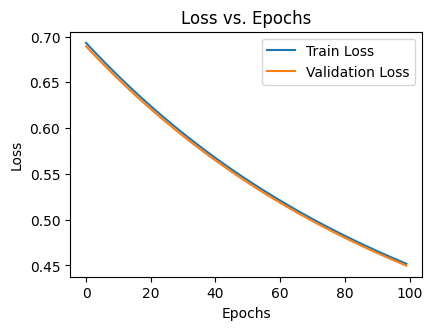

In [32]:
# 绘制训练损失和验证损失与epoch的关系
plt.figure(figsize=(10, 7))
plt.subplot(2, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()

print(f"Average Training Loss: {np.average(train_loss)}")
print(f"Average Validation Loss: {np.average(validation_loss)}")

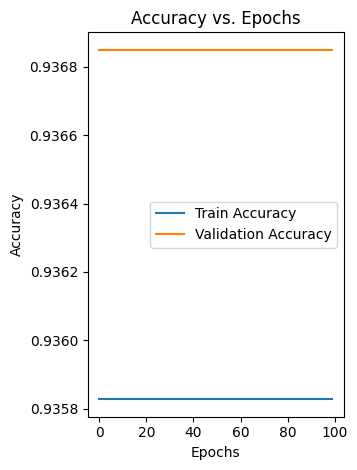

Average Training Accuracy: 0.9358279643299057
Average Validation Accuracy: 0.9368492916880018


In [33]:
# 准确率图
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# 打印最终的平均准确率
print(f"Average Training Accuracy: {np.mean(train_accuracies)}")
print(f"Average Validation Accuracy: {np.mean(validation_accuracies)}")

# 1.2 KNN Classifier

In [23]:
# 欧几里得距离
def euclidean_distance(row1, row2):
    return np.sum((row1 - row2) ** 2)#sqrt先去掉，爲了提高性能

# 曼哈顿距离
def manhattan_distance(row1, row2):
    return np.sum(abs(row1 - row2))

# 切比雪夫距离
def chebyshev_distance(row1, row2):
    return np.max(abs(row1 - row2))

In [28]:
# KNN算法实现，仅针对随机选择的五个数据点
def knn_classify(training_data, test_data, k, distance_func):
    predictions = []
    # 从测试数据中随机选择五个点
    random_indices = np.random.choice(range(len(test_data)), 100, replace=False)
    random_test_samples = test_data.iloc[random_indices]
    
    for i in tqdm(range(len(random_test_samples))):
        # 计算距离并排序
        distances = np.apply_along_axis(distance_func, 1, training_data, random_test_samples.iloc[i])
        sorted_distances_indices = np.argsort(distances)
        # 选择前k个最近邻
        nearest_labels = y_train.iloc[sorted_distances_indices[:k]]
        
        # 投票得到预测结果
        vote_result = nearest_labels.mode()[0]
        predictions.append(vote_result)
    return predictions, random_indices

In [25]:
# 计算准确率
def accuracy_score(true_labels, predictions):
    return (true_labels == predictions).mean()

# 划分特征和目标列
features = train_set.drop('is_claim', axis=1)
labels = train_set['is_claim']

features_validation = validation_set.drop('is_claim', axis=1)
labels_validation = validation_set['is_claim']

In [29]:
# 分别使用三种距离度量进行KNN分类
k = 5
accuracy_results = {}

for distance_func in [euclidean_distance, manhattan_distance, chebyshev_distance]:
    predictions, random_indices = knn_classify(pd.concat([features, labels], axis=1), pd.concat([features_validation, labels_validation], axis=1), k, distance_func)
    # 根据随机选取的点计算准确率
    accuracy = accuracy_score(labels_validation.iloc[random_indices], predictions)
    accuracy_results[distance_func.__name__] = accuracy

  0%|          | 0/100 [00:00<?, ?it/s]100%|██████████| 100/100 [13:35<00:00,  8.15s/it]

100%|██████████| 100/100 [13:24<00:00,  8.05s/it]

100%|██████████| 100/100 [12:50<00:00,  7.71s/it]


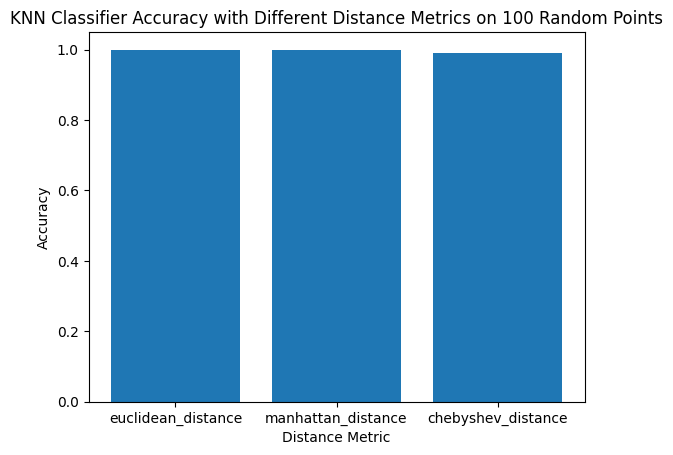

In [30]:
# 绘制准确率
plt.bar(accuracy_results.keys(), accuracy_results.values())
plt.xlabel('Distance Metric')
plt.ylabel('Accuracy')
plt.title('KNN Classifier Accuracy with Different Distance Metrics on 100 Random Points')
plt.show()

# 1.3/4 Decision Tree (with Pruning)

In [31]:
# 定义节点类
class Node:
    def __init__(self, value=None, true_branch=None, false_branch=None, is_leaf=False):
        self.value = value
        self.true_branch = true_branch
        self.false_branch = false_branch
        self.is_leaf = is_leaf
    
    def get_description(self):
        if self.is_leaf:
            return f"Leaf Node: Predicts class {self.value}"
        else:
            return f"Decision Node: {self.value[0]} <= {self.value[1]}"
        


In [40]:
class DecisionTree:
    # 添加一个属性来保存每一次迭代的性能指标
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.best_gini = float('inf')
        self.best_criteria = None
        self.best_sets = None
        self.tree = None
        self.history = {'depth': [], 'train_accuracy': [], 'train_loss': [], 'test_accuracy': [], 'test_loss': []}
        self.import_feature = set()
        
    def split_data(self, data, feature, value):
        
        true_data = data[data[feature] <= value]
        false_data = data[data[feature] > value]
        return true_data, false_data
    
        return train_data, test_data
    def find_best_split(self, data):
        features = data.columns[:-1]
        self.best_gini = float('inf')  # 重置best_gini
        for feature in features:
            unique_values = data[feature].unique()
#             print(len(unique_values))
            for value in tqdm(unique_values,total = len(unique_values)):
                true_data, false_data = self.split_data(data, feature, value)
                gini = (len(true_data) / len(data)) * self.calculate_gini(true_data) + \
                       (len(false_data) / len(data)) * self.calculate_gini(false_data)
#                 print(feature)

                if gini < self.best_gini:
                    self.best_gini = gini
                    self.best_criteria = (feature, value)
                    self.best_sets = (true_data, false_data)
#                     print(self.best_criteria[0])
                    
                    if self.best_criteria[0] not in self.import_feature:
                        self.import_feature.add(self.best_criteria[0])
            
        
        return self.best_criteria, self.best_sets

    def build_tree(self, data, depth=0):
        
#         print(self.best_sets[1])
        if depth == self.max_depth :#or self.best_sets is None:
#             print(depth == self.max_depth)
#             print(self.best_sets)
#             print(self.best_sets is None)
#             print(data['is_claim'].iloc[0])
            return Node(value=data['is_claim'].iloc[0], is_leaf=True)
        else:
            self.best_criteria, self.best_sets = self.find_best_split(data)
            if self.best_gini == 0:
                return Node(value=self.best_sets[0]['is_claim'].mode()[0], is_leaf=True)
            if self.best_sets[0].shape[0] or self.best_sets[1].shape[0] <100:
                return Node(value=self.best_sets[0]['is_claim'].mode()[0], is_leaf=True)
            true_branch = self.build_tree(self.best_sets[0], depth + 1)
            false_branch = self.build_tree(self.best_sets[1], depth + 1)
            print(depth)

            return Node(value=self.best_criteria, true_branch=true_branch, false_branch=false_branch)
    
    def prune_tree(self, X_val, y_val, node=None):
        if node is None:
            node = self.tree

        # 如果当前节点是叶节点，则不需要剪枝
        if node.is_leaf:
            return
        
        # 如果当前节点有子节点，先尝试剪枝子节点
        if node.true_branch:
            self.prune_tree(X_val, y_val, node.true_branch)
        if node.false_branch:
            self.prune_tree(X_val, y_val, node.false_branch)
        
        # 检查当前节点如果被剪枝，是否能提高验证集的准确率
        before_prune_accuracy = self.eva(X_val, y_val)
        
        # 将当前节点变为叶节点
        true_backup, false_backup = node.true_branch, node.false_branch
        node.true_branch, node.false_branch = None, None
        node.is_leaf = True
        node.value = self.majority_class(y_val)
        
        after_prune_accuracy = self.eva(X_val, y_val)
        
        # 如果剪枝后准确率下降，撤销剪枝
        if after_prune_accuracy < before_prune_accuracy:
            node.true_branch, node.false_branch = true_backup, false_backup
            node.is_leaf = False
    
    
    def train(self, train_data, test_data=None):
        # 重构训练函数，根据每个深度构建树并评估性能
        for depth in range(1, self.max_depth + 1):
            self.tree = self.build_tree(train_data, depth)
            self.evaluate(train_data, test_data, depth)
            
            # 計算訓練集的準確度和損失
            train_predictions = self.predict(train_data.drop(columns=['is_claim']))
            train_labels = train_data['is_claim'].values
            train_accuracy = np.sum(train_predictions == train_labels) / len(train_labels)
            train_loss = self.calculate_gini(train_data[train_data['is_claim'] != train_predictions])
            
    def evaluate(self, train_data, test_data, depth):
        # 计算训练集的准确度和损失
        train_predictions = self.predict(train_data.drop(columns=['is_claim']))
        train_labels = train_data['is_claim'].values
        train_accuracy = np.sum(train_predictions == train_labels) / len(train_labels)
        train_loss = self.calculate_gini(train_data)

        # 保存训练集的性能
        self.history['depth'].append(depth)
        self.history['train_accuracy'].append(train_accuracy)
        self.history['train_loss'].append(train_loss)

        if test_data is not None:
            # 计算测试集的准确度和损失
            test_predictions = self.predict(test_data.drop(columns=['is_claim']))
            test_labels = test_data['is_claim'].values
            test_accuracy = np.sum(test_predictions == test_labels) / len(test_labels)
            test_loss = self.calculate_gini(test_data)

            # 保存测试集的性能
            self.history['test_accuracy'].append(test_accuracy)
            self.history['test_loss'].append(test_loss)
                
    def eva(self, X_val, y_val):
        predictions = self.predict(X_val)
        prune_accuracy = np.sum(predictions == y_val) / len(y_val)
        return prune_accuracy

    def majority_class(self, y):
        values, counts = np.unique(y, return_counts=True)
        max_count_index = np.argmax(counts)
        return values[max_count_index]

    
    # 添加一个方法来计算Gini不纯度作为损失
    def calculate_gini(self, data):
        if len(data) == 0:
            return 0
        else:
            proportions = data['is_claim'].value_counts(normalize=True)
            gini = 1 - sum(proportions ** 2)
            return gini
    
    def calculate_loss(self, predictions, labels):
        # 计算二分类的损失，这里用简单的错误率来表示损失
        loss = np.sum(predictions != labels) / float(len(labels))
        return loss
    

    # 预测单个样本
    def predict_sample(self, node, sample):
        if node.is_leaf:
            return node.value

        feature, value = node.value
        if sample[feature] <= value:
            return self.predict_sample(node.true_branch, sample)
        else:
            return self.predict_sample(node.false_branch, sample)

    # 预测数据集
    def predict(self, data):
        predictions = np.array([self.predict_sample(self.tree, row) for _, row in data.iterrows()])
        return predictions

In [34]:
def split_dataset(data, test_size=0.2):
    # 随机打乱数据集
    data = data.sample(frac=1.0, random_state=42).reset_index(drop=True)
    
    # 计算测试集的大小
    test_data_size = int(test_size * len(data))
    
    # 划分数据集
    test_data = data[:test_data_size]
    train_data = data[test_data_size:]
    
    return train_data, test_data

In [36]:
trainData = pd.read_csv(csv_path, header=0)
# 刪除第一、十一、十二列的單元格
trainData = trainData.drop(columns=[trainData.columns[0], trainData.columns[10], trainData.columns[11]])
def encode_non_numeric(column):
    if column.dtype == 'object':
        return column.astype('category').cat.codes
    return column

# 將所有非數字的單元格進行編碼
trainData = trainData.apply(encode_non_numeric)

In [43]:
# 划分数据集
trainData, testData = split_dataset(trainData)

print("Training set size:", trainData.shape)
print("Validation set size:", testData.shape)

# 使用上述决策树类进行训练和预测
tree = DecisionTree(max_depth=5) # 假设我们想要训练深度为1到5的树
tree.train(trainData, testData)

tree.prune_tree(X_val=testData.drop(columns=['is_claim']), y_val=testData['is_claim'])

# 预测训练集数据
train_predictions = tree.predict(trainData.drop(columns=['is_claim']))
train_labels = trainData['is_claim'].values

# 计算训练集准确度和损失
train_accuracy = np.sum(train_predictions == train_labels) / len(train_labels)


# 预测测试集数据
test_predictions = tree.predict(testData.drop(columns=['is_claim']))
test_labels = testData['is_claim'].values

# 计算测试集准确度
test_accuracy = np.sum(test_predictions == test_labels) / len(test_labels)

Training set size: (19200, 41)

Validation set size: (4800, 41)


  0%|          | 0/19200 [00:00<?, ?it/s]100%|██████████| 19200/19200 [01:04<00:00, 296.37it/s]

100%|██████████| 42/42 [00:00<00:00, 309.69it/s]

100%|██████████| 70/70 [00:00<00:00, 306.61it/s]

100%|██████████| 22/22 [00:00<00:00, 306.15it/s]

100%|██████████| 22/22 [00:00<00:00, 294.18it/s]

100%|██████████| 5/5 [00:00<00:00, 295.06it/s]

100%|██████████| 6/6 [00:00<00:00, 300.42it/s]

100%|██████████| 11/11 [00:00<00:00, 234.98it/s]

100%|██████████| 3/3 [00:00<00:00, 250.86it/s]

100%|██████████| 11/11 [00:00<00:00, 289.68it/s]

100%|██████████| 3/3 [00:00<00:00, 175.93it/s]

100%|██████████| 2/2 [00:00<00:00, 250.63it/s]

100%|██████████| 2/2 [00:00<00:00, 222.98it/s]

100%|██████████| 2/2 [00:00<00:00, 250.59it/s]

100%|██████████| 2/2 [00:00<00:00, 250.59it/s]

100%|██████████| 2/2 [00:00<00:00, 222.97it/s]

100%|██████████| 2/2 [00:00<00:00, 250.82it/s]

100%|██████████| 9/9 [00:00<00:00, 273.62it/s]

100%|██████████| 2/2 [00:00<00:00, 286.27it/s]

100%|██████████| 2/2 [00:00

In [46]:
print(tree.import_feature)

{'policy_tenure'}


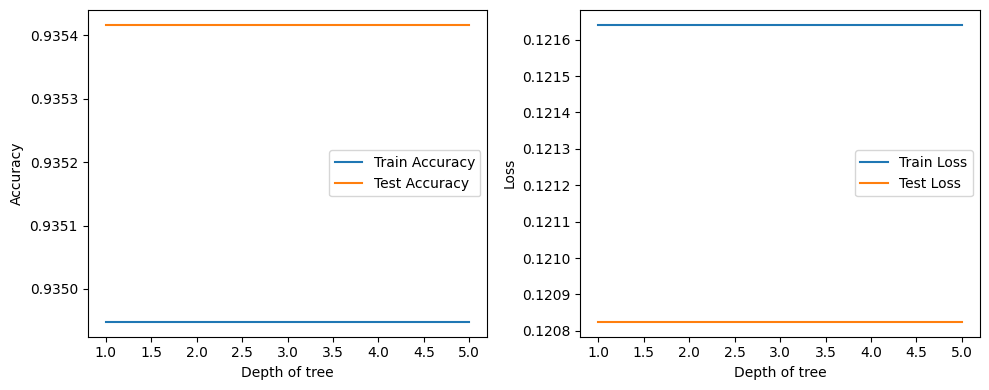

[0.12164061957465289, 0.12164061957465289, 0.12164061957465289, 0.12164061957465289, 0.12164061957465289]

[0.12082465277777776, 0.12082465277777776, 0.12082465277777776, 0.12082465277777776, 0.12082465277777776]

Average Testing Accuracy: 0.935417

Average Training Accuracy: 0.934948


In [45]:
# 繪製性能圖表
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(tree.history['depth'], tree.history['train_accuracy'], label='Train Accuracy')
plt.plot(tree.history['depth'], tree.history['test_accuracy'], label='Test Accuracy')
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(tree.history['depth'], tree.history['train_loss'], label='Train Loss')
plt.plot(tree.history['depth'], tree.history['test_loss'], label='Test Loss')
plt.xlabel('Depth of tree')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print(tree.history['train_loss'])
print(tree.history['test_loss'])
print(f'Average Testing Accuracy: {test_accuracy:.6f}')
print(f'Average Training Accuracy: {train_accuracy:.6f}')

# 2. Feature Engineering

# 2.1 Feature Importance

**此爲決策樹的重要特徵**

In [ ]:
print(tree.import_feature)

**此爲綫性分類器的重要特徵**

In [34]:
def select_feature(weight,feature_name,thresho = 0.5):
    threshold = thresho * np.mean(np.abs(weight))

    # 找出绝对值大于阈值的权重的索引
    important_features_indices = np.where(np.abs(weight) > threshold)[0]

    # 打印出重要特征的索引
    print("Important features indices:", important_features_indices)

    # 如果你有一个对应于权重的特征名称列表，你也可以这样打印出来
    feature_names = feature_name  # 这应该是与权重对应的特征名称列表
    important_features_names = [feature_names[i] for i in important_features_indices]
    print("Important features names:", important_features_names)
    
select_feature(classifier.weights,X_train.columns)

Important features indices: [ 0 37]
Important features names: ['age_of_car', 'intercept']


# 2.2.1 Shap for Linear Classifier

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


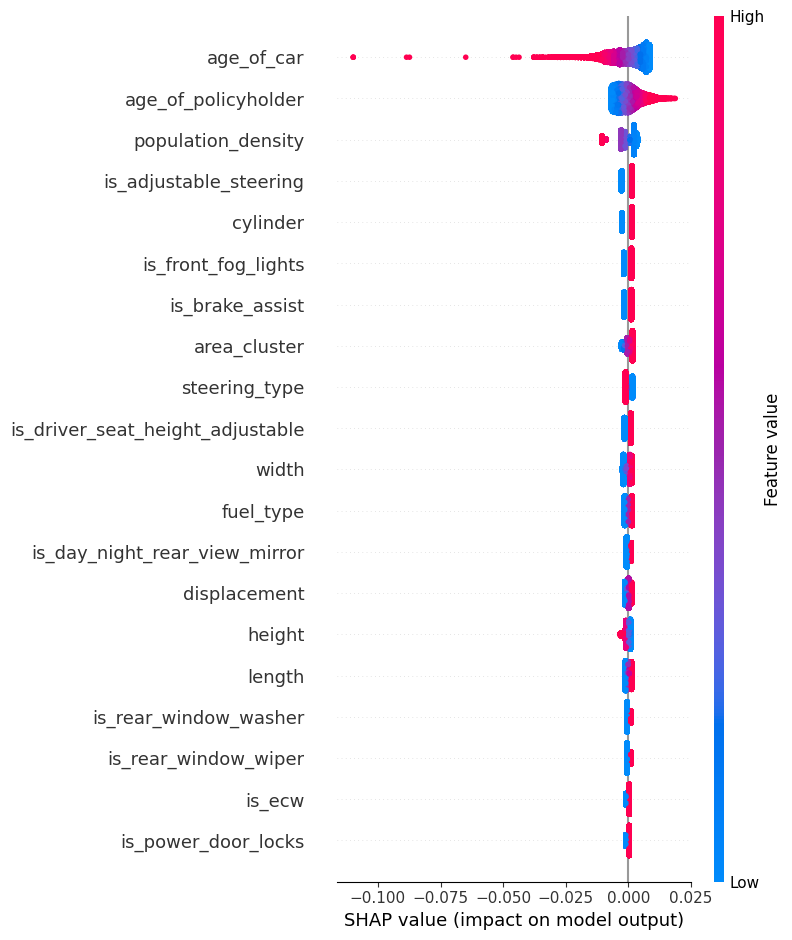

In [35]:
explainer = shap.LinearExplainer(classifier, X_train.to_numpy(), feature_dependence="independent")
shap_values = explainer.shap_values(X_train.to_numpy())
shap.summary_plot(shap_values, X_train.to_numpy(), feature_names=X_train.columns.tolist())

# 2.2.2 Shap for Decesion Tree

**因爲SHAP要求的決策樹構型與我創建的不同，這裏使用SKLEARN的基礎決策樹進行SHAP演示**

Accuracy on validation set: 0.93710530807305

              precision    recall  f1-score   support



           0       0.94      1.00      0.97     10981

           1       0.00      0.00      0.00       737



    accuracy                           0.94     11718

   macro avg       0.47      0.50      0.48     11718

weighted avg       0.88      0.94      0.91     11718




Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


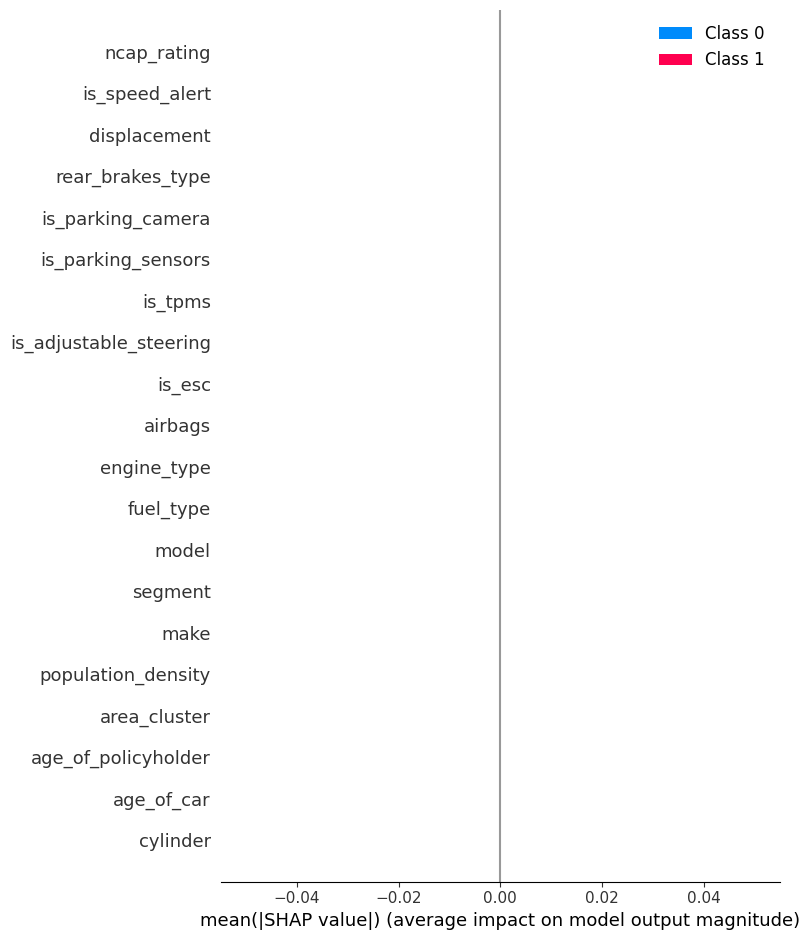

In [74]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import shap

# 准备数据
X_train = train_set.drop('is_claim', axis=1)
y_train = train_set['is_claim']
X_validation = validation_set.drop('is_claim', axis=1)
y_validation = validation_set['is_claim']

# 训练决策树模型
# 注意：您可以通过调整DecisionTreeClassifier的参数来实现不同程度的剪枝
dt_classifier = DecisionTreeClassifier(random_state=42, ccp_alpha=0.01)  # ccp_alpha是剪枝的复杂性参数
dt_classifier.fit(X_train, y_train)

# 模型评估
y_pred = dt_classifier.predict(X_validation)
print("Accuracy on validation set:", accuracy_score(y_validation, y_pred))
print(classification_report(y_validation, y_pred))

# 使用SHAP进行模型解释
explainer = shap.TreeExplainer(dt_classifier)
shap_values = explainer.shap_values(X_validation)

# 可视化第一个预测的SHAP值
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_validation.iloc[0,:])

# 可视化特征的重要性
shap.summary_plot(shap_values, X_validation)

# 2.3 Custom Algorithm

In [208]:
def generate_correlation_feature(data, label = 'is_claim', correlation_threshold_low = 0.5, correlation_threshold_high=0.8):
    # 計算特徵之間的相關性矩陣
    label = data[label]
    data = data.drop(columns="is_claim")
    correlation_matrix = data.corr().abs()

    # 取得高於閾值的相關性對
    high_corr_pairs = np.where((correlation_matrix > correlation_threshold_low) & (correlation_matrix < correlation_threshold_high))

    # 創建一個新的 DataFrame 來存放生成的特徵
    new_features = pd.DataFrame()

    # 遍歷相關性高於閾值的特徵對
    for feature1, feature2 in zip(*high_corr_pairs):
        # 確保不重複添加相同的特徵對
        if feature1 < feature2:
            # 生成新特徵，這裡使用相乘，你可以根據需求修改這個部分
            new_feature_name = f"{data.columns[feature1]}_{data.columns[feature2]}_product"
            new_features[new_feature_name] = data.iloc[:, feature1] * data.iloc[:, feature2]

    # 將生成的新特徵合併到原始資料中
    data = pd.concat([data, new_features, label], axis=1)

    return data

In [209]:
md = generate_correlation_feature(metaData,correlation_threshold_low = 0.6,correlation_threshold_high = 0.8)

In [210]:
# md["tp"] = md.iloc[:,0]*md.age_of_car
t1, v1 = split_train_validation(md, test_ratio=0.2)

t_x = t1.drop('is_claim', axis=1)
t_y = t1['is_claim']
v_x = v1.drop('is_claim', axis=1)
v_y = v1['is_claim']


In [219]:
classifier = LinearClassifier()
train_accuracies, validation_accuracies, train_loss, validation_loss = classifier.fit(t_x.values, t_y.values, v_x.values, v_y.values, epochs=100, lr=0.001)

  0%|          | 0/100 [00:00<?, ?it/s]overflow encountered in exp

100%|██████████| 100/100 [00:02<00:00, 49.57it/s]


**驗證：使用linear classifier做測試 如果accuracy成功提升證明新的特徵有效
此時可以觀察到驗證集準確率有所上升，代表特徵工程正確**

In [221]:
max(validation_accuracies)

0.9362519201228878

In [223]:
t2, v2 = split_train_validation(metaData, test_ratio=0.2)

t_x = t2.drop('is_claim', axis=1)
t_y = t2['is_claim']
v_x = v2.drop('is_claim', axis=1)
v_y = v2['is_claim']

classifier = LinearClassifier()
train_accuracies, validation_accuracies, train_loss, validation_loss = classifier.fit(t_x.values, t_y.values, v_x.values, v_y.values, epochs=50, lr=0.0001)

  0%|          | 0/50 [00:00<?, ?it/s]overflow encountered in exp

100%|██████████| 50/50 [00:01<00:00, 46.60it/s]


In [224]:
max(validation_accuracies)

0.9310462536268987

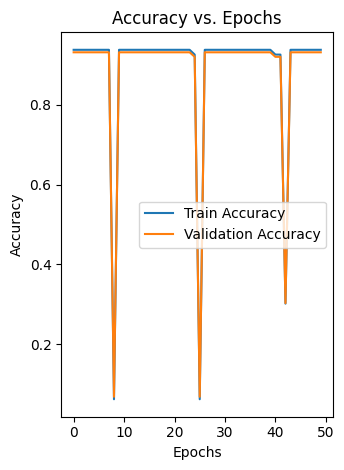

Average Training Accuracy: 0.8888731492938515

Average Validation Accuracy: 0.8833265062297319


In [225]:
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# 打印最终的平均准确率
print(f"Average Training Accuracy: {np.mean(train_accuracies)}")
print(f"Average Validation Accuracy: {np.mean(validation_accuracies)}")

# 3. Cross Vaildation

In [37]:
# metaData.columns
cv_X = metaData.drop('is_claim', axis=1)
cv_y = metaData['is_claim']

In [38]:
def kfold(train_d,labels,k=3):
    data_size = len(train_d)
    fold_size = data_size // k
    
    indices = np.arange(data_size)
    np.random.shuffle(indices)

    for i in range(k):
        start = i * fold_size
        end = (i + 1) * fold_size

        val_indices = indices[start:end]
        train_indices = np.concatenate([indices[:start], indices[end:]])

        val_data, val_labels = train_d.iloc[val_indices], labels.iloc[val_indices]
        train_data, train_labels = train_d.iloc[train_indices], labels.iloc[train_indices]

        yield train_data, train_labels, val_data, val_labels

**在這裏修改K值**

In [43]:
kf = kfold(cv_X, cv_y, k=5)

In [ ]:
val_acces = []

kf = kfold(cv_X, cv_y, k=3)
#train_losses, validation_losses = classifier.fit(X_train.values, y_train.values, X_validation.values, y_validation.values, epochs=1000, lr=0.01)
# train_accuracies, validation_accuracies, train_loss, validation_loss = classifier.fit(X_train.values, y_train.values, X_validation.values, y_validation.values, epochs=100, lr=0.01)
for train_data, train_labels, val_data, val_labels in kf:
    # 在這裡進行模型的訓練和驗證
    classifier = LinearClassifier()

    print("Train Data Size:", len(train_data))
    print("Validation Data Size:", len(val_data))
    train_accuracies, validation_accuracies, train_loss, validation_loss = classifier.fit(train_data.values, train_labels.values, val_data.values, 
                   val_labels.values, epochs=100, lr=0.01)
    print("test_acc",np.mean(validation_accuracies))
    val_acces.append(np.mean(validation_accuracies))

In [44]:
val_acces = []

kf = kfold(cv_X, cv_y, k=5)
#train_losses, validation_losses = classifier.fit(X_train.values, y_train.values, X_validation.values, y_validation.values, epochs=1000, lr=0.01)
# train_accuracies, validation_accuracies, train_loss, validation_loss = classifier.fit(X_train.values, y_train.values, X_validation.values, y_validation.values, epochs=100, lr=0.01)
for train_data, train_labels, val_data, val_labels in kf:
    # 在這裡進行模型的訓練和驗證
    classifier = LinearClassifier()

    print("Train Data Size:", len(train_data))
    print("Validation Data Size:", len(val_data))
    train_accuracies, validation_accuracies, train_loss, validation_loss = classifier.fit(train_data.values, train_labels.values, val_data.values, 
                   val_labels.values, epochs=100, lr=0.01)
    print("test_acc",np.mean(validation_accuracies))
    val_acces.append(np.mean(validation_accuracies))

Train Data Size: 46874
Validation Data Size: 11718


100%|██████████| 100/100 [00:06<00:00, 14.60it/s]


test_acc 0.8818228366615465
Train Data Size: 46874
Validation Data Size: 11718


100%|██████████| 100/100 [00:06<00:00, 15.38it/s]


test_acc 0.8798003072196622
Train Data Size: 46874
Validation Data Size: 11718


100%|██████████| 100/100 [00:06<00:00, 15.39it/s]


test_acc 0.8814251578767707
Train Data Size: 46874
Validation Data Size: 11718


100%|██████████| 100/100 [00:06<00:00, 15.41it/s]


test_acc 0.8798566308243728
Train Data Size: 46874
Validation Data Size: 11718


100%|██████████| 100/100 [00:06<00:00, 15.54it/s]

test_acc 0.8799854924048472


In [ ]:
val_acces = []

kf = kfold(cv_X, cv_y, k=10)
#train_losses, validation_losses = classifier.fit(X_train.values, y_train.values, X_validation.values, y_validation.values, epochs=1000, lr=0.01)
# train_accuracies, validation_accuracies, train_loss, validation_loss = classifier.fit(X_train.values, y_train.values, X_validation.values, y_validation.values, epochs=100, lr=0.01)
for train_data, train_labels, val_data, val_labels in kf:
    # 在這裡進行模型的訓練和驗證
    classifier = LinearClassifier()

    print("Train Data Size:", len(train_data))
    print("Validation Data Size:", len(val_data))
    train_accuracies, validation_accuracies, train_loss, validation_loss = classifier.fit(train_data.values, train_labels.values, val_data.values, 
                   val_labels.values, epochs=100, lr=0.01)
    print("test_acc",np.mean(validation_accuracies))
    val_acces.append(np.mean(validation_accuracies))

In [45]:
val_acces

[0.8818228366615465,
 0.8798003072196622,
 0.8814251578767707,
 0.8798566308243728,
 0.8799854924048472]

In [ ]:
kf = kfold(cv_X, cv_y, k=3)
k = 5
accuracy_results = {}
acc_l = []
for train_data, train_labels, val_data, val_labels in kf:
    # 在這裡進行模型的訓練和驗證
    print("Train Data Size:", len(train_data))
    print("Validation Data Size:", len(val_data))
    train_accuracies, validation_accuracies, train_loss, validation_loss = classifier.fit(train_data.values, train_labels.values, val_data.values, 
                   val_labels.values, epochs=100, lr=0.01)
    for distance_func in [euclidean_distance]:#, manhattan_distance, chebyshev_distance
        predictions, random_indices = knn_classify(pd.concat([train_data, train_labels], axis=1), pd.concat([val_data, val_labels], axis=1), k, distance_func)
        # 根据随机选取的点计算准确率
        accuracy = accuracy_score(val_labels.iloc[random_indices], predictions)
        accuracy_results[distance_func.__name__] = accuracy
    acc_l.append(accuracy_results)

In [46]:
kf = kfold(cv_X, cv_y, k=5)
k = 5
accuracy_results = {}
acc_l = []
for train_data, train_labels, val_data, val_labels in kf:
    # 在這裡進行模型的訓練和驗證
    print("Train Data Size:", len(train_data))
    print("Validation Data Size:", len(val_data))
    train_accuracies, validation_accuracies, train_loss, validation_loss = classifier.fit(train_data.values, train_labels.values, val_data.values, 
                   val_labels.values, epochs=100, lr=0.01)
    for distance_func in [euclidean_distance]:#, manhattan_distance, chebyshev_distance
        predictions, random_indices = knn_classify(pd.concat([train_data, train_labels], axis=1), pd.concat([val_data, val_labels], axis=1), k, distance_func)
        # 根据随机选取的点计算准确率
        accuracy = accuracy_score(val_labels.iloc[random_indices], predictions)
        accuracy_results[distance_func.__name__] = accuracy
    acc_l.append(accuracy_results)

Train Data Size: 46874
Validation Data Size: 11718


100%|██████████| 100/100 [27:14<00:00, 16.34s/it]


Train Data Size: 46874
Validation Data Size: 11718


100%|██████████| 100/100 [27:03<00:00, 16.24s/it]


Train Data Size: 46874
Validation Data Size: 11718


100%|██████████| 100/100 [27:28<00:00, 16.49s/it]


Train Data Size: 46874
Validation Data Size: 11718


100%|██████████| 100/100 [27:36<00:00, 16.56s/it]


Train Data Size: 46874
Validation Data Size: 11718


100%|██████████| 100/100 [27:34<00:00, 16.55s/it]


In [ ]:
kf = kfold(cv_X, cv_y, k=10)
k = 5
accuracy_results = {}
acc_l = []
for train_data, train_labels, val_data, val_labels in kf:
    # 在這裡進行模型的訓練和驗證
    print("Train Data Size:", len(train_data))
    print("Validation Data Size:", len(val_data))
    train_accuracies, validation_accuracies, train_loss, validation_loss = classifier.fit(train_data.values, train_labels.values, val_data.values, 
                   val_labels.values, epochs=100, lr=0.01)
    for distance_func in [euclidean_distance]:#, manhattan_distance, chebyshev_distance
        predictions, random_indices = knn_classify(pd.concat([train_data, train_labels], axis=1), pd.concat([val_data, val_labels], axis=1), k, distance_func)
        # 根据随机选取的点计算准确率
        accuracy = accuracy_score(val_labels.iloc[random_indices], predictions)
        accuracy_results[distance_func.__name__] = accuracy
    acc_l.append(accuracy_results)

In [47]:
acc_l

[{'euclidean_distance': 0.95},
 {'euclidean_distance': 0.95},
 {'euclidean_distance': 0.95},
 {'euclidean_distance': 0.95},
 {'euclidean_distance': 0.95}]

In [ ]:
kf = kfold(cv_X, cv_y, k=3)
acc_dec = []
for train_data, train_labels, val_data, val_labels in kf:
    tree = DecisionTree(max_depth=3) # 假设我们想要训练深度为1到3的树

    trainData = pd.concat([train_data, train_labels], axis=1)
    testData = pd.concat([val_data, val_labels], axis=1)
    tree.train(trainData, testData)

    test_predictions = tree.predict(testData.drop(columns=['is_claim']))
    test_labels = testData['is_claim'].values

    test_accuracy = np.sum(test_predictions == test_labels) / len(test_labels)
    acc_dec.append(test_accuracy)

In [238]:
kf = kfold(cv_X, cv_y, k=5)
acc_dec = []
for train_data, train_labels, val_data, val_labels in kf:
    tree = DecisionTree(max_depth=3) # 假设我们想要训练深度为1到3的树

    trainData = pd.concat([train_data, train_labels], axis=1)
    testData = pd.concat([val_data, val_labels], axis=1)
    tree.train(trainData, testData)

    test_predictions = tree.predict(testData.drop(columns=['is_claim']))
    test_labels = testData['is_claim'].values

    test_accuracy = np.sum(test_predictions == test_labels) / len(test_labels)
    acc_dec.append(test_accuracy)

  0%|          | 0/39062 [00:00<?, ?it/s]100%|██████████| 39062/39062 [05:14<00:00, 124.33it/s]

100%|██████████| 47/47 [00:00<00:00, 122.49it/s]

100%|██████████| 73/73 [00:00<00:00, 119.94it/s]

100%|██████████| 22/22 [00:00<00:00, 116.13it/s]

100%|██████████| 22/22 [00:00<00:00, 127.52it/s]

100%|██████████| 5/5 [00:00<00:00, 128.60it/s]

100%|██████████| 6/6 [00:00<00:00, 122.82it/s]

100%|██████████| 11/11 [00:00<00:00, 131.22it/s]

100%|██████████| 3/3 [00:00<00:00, 130.90it/s]

100%|██████████| 11/11 [00:00<00:00, 128.22it/s]

100%|██████████| 3/3 [00:00<00:00, 130.80it/s]

100%|██████████| 2/2 [00:00<00:00, 133.79it/s]

100%|██████████| 2/2 [00:00<00:00, 133.78it/s]

100%|██████████| 2/2 [00:00<00:00, 125.33it/s]

100%|██████████| 2/2 [00:00<00:00, 125.36it/s]

100%|██████████| 2/2 [00:00<00:00, 133.72it/s]

100%|██████████| 2/2 [00:00<00:00, 125.36it/s]

100%|██████████| 9/9 [00:00<00:00, 127.18it/s]

100%|██████████| 2/2 [00:00<00:00, 118.00it/s]

100%|██████████| 2/2 [00:00

In [ ]:
kf = kfold(cv_X, cv_y, k=10)
acc_dec = []
for train_data, train_labels, val_data, val_labels in kf:
    tree = DecisionTree(max_depth=3) # 假设我们想要训练深度为1到3的树

    trainData = pd.concat([train_data, train_labels], axis=1)
    testData = pd.concat([val_data, val_labels], axis=1)
    tree.train(trainData, testData)

    test_predictions = tree.predict(testData.drop(columns=['is_claim']))
    test_labels = testData['is_claim'].values

    test_accuracy = np.sum(test_predictions == test_labels) / len(test_labels)
    acc_dec.append(test_accuracy)

In [239]:
acc_dec

[0.9355350742447517, 0.9355862775217614, 0.9369687660010241]

In [ ]:
def vote(x,models):

    results = []
    for model in models:

        results.append(model.predict(x))
        # print(self.c)
    results = np.array(results)
    
    mode_result = np.apply_along_axis(lambda arr: np.argmax(np.bincount(arr)), axis=0, arr=results)


    return mode_result

In [233]:
val_acces = []
classifer_list = []
kf = kfold(cv_X, cv_y, k=5)

for train_data, train_labels, val_data, val_labels in kf:
    # 在這裡進行模型的訓練和驗證
    classifier = LinearClassifier()
    train_accuracies, validation_accuracies, train_loss, validation_loss = classifier.fit(train_data.values, train_labels.values, val_data.values, 
                   val_labels.values, epochs=100, lr=0.01)
    print("test_acc",np.mean(validation_accuracies))
    val_acces.append(np.mean(validation_accuracies))

    classifer_list.append(classifier)


vote_result = vote(val_data.values,classifer_list)
voter_acc = sum(vote_result == val_labels.values)


[]